# MATEMATYKA FINANSOWA - Laboratorium 5
Stanisław Pawlak

In [1]:
import scipy.stats
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import  e, sqrt, factorial, floor, log

## Zadanie 1

$ c(S_{0},T,K,\sigma,r) :=S_{0}\Phi(d_{+}(S_{0},T,K,\sigma,r))− Ke^{−rT}\Phi(d_{−}(S_{0},T,K,\sigma,r)),$

gdzie $\Phi$ jest dystrybuantą rozkładu $N(0,1)$ oraz 

$ d_{±}(S_{0},T,K,\sigma,r) :=\frac{log \frac{S_{0}}{K} + (r± \frac{\sigma^{2}}{2})T}{\sigma \sqrt{T}}.$

Zauważmy też, że $d_{+}() = d_{-}() - \sigma \sqrt{T}$

In [2]:
def d1(S0, T, K, sigma, r):
    return (log(S0/K) + (r + sigma**2 /2)*T)/(sigma*sqrt(T))

def d2(S0, T, K, sigma, r):
    return d1(S0, T, K, sigma, r) -  sigma*sqrt(T)

def BS_price(S0, T, K, sigma, r):
    return S0* norm.cdf(d1(S0, T, K, sigma, r)) - K*e**(-r*T)*norm.cdf(d2(S0, T, K, sigma, r))

BS_price(100, 1, 100, 0.1, 0.1)

10.308150925634422

Implementacja Modelu CRR:

In [3]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()


In [4]:
class BankAccount:
    def __init__(self, r):
        self.r = r

    def get_bank_account_value(self, t):
        return (1 + self.r) ** t


class MarketInstrument:
    def __init__(self, S_0):
        self.S_0 = S_0

    def calculate_call_option_value(self, market, T, K):
        return self._calculate_option_value(self.get_call_option_value, market, T, K)
        
    def calculate_put_option_value(self, market, T, K):
        return self._calculate_option_value(self.get_put_option_value, market, T, K)

    def _calculate_option_value(self, option_func_type, market, t, K):
        prices = [option_func_type(t, t-j, market.d, market.u, K) for j in range(0, t+1)]
        return self._get_value(t, prices, market.d, market.u, market.r, market.p)
    
    def _get_value(self, t, prices, d, u,r, p):
        if t == 0:
            return prices[0]
        else:
            for i in range(0, t):
                prices[i] =1/(1+r)*(p*prices[i] + (1-p)*prices[i+1])
            #print(prices[:t])
            return self._get_value(t-1, prices, d, u,r,  p)

    
    def get_call_option_value(self, t, j, d, u, K):
        return max(self.S_0 * u ** j * d ** (t - j) - K, 0)
    
    def get_put_option_value(self, t, j, d, u, K):
        return max(K - self.S_0 * u ** j * d ** (t - j), 0)

hide_toggle()

In [5]:
class CRRMarket:
    def __init__(self, S_0_values, d, u, r, T):
        self.B = BankAccount(r)
        self.p = (1 + r - d) / (u - d)
        self.S = [MarketInstrument(S_0_values[i]) for i in range(0, len(S_0_values))]
        self.d = d
        self.u = u
        self.r = r
        self.T = T
    
    def calculate_call_options_values(self, T, K):
        return [s.calculate_call_option_value(self, T, K[i]) for i, s in enumerate(self.S)]
    
    def calculate_put_options_values(self, T, K):
        return [s.calculate_put_option_value(self, T, K[i]) for i, s in enumerate(self.S)]
    
hide_toggle()

In [6]:
import scipy.special
def calculate_option_value_theory(option_func_type, market, t, K):
        scaling_value = 1 / market.B.get_bank_account_value(t)
        sum = 0
        for j in range(0, t+1):
            sum += scipy.special.comb(t, j, exact=True) * market.p ** j * (1 - market.p) ** (t - j) * option_func_type(t, j, market.d, market.u, K)
        return sum * scaling_value
hide_toggle()

In [7]:
def CRR_prep(T, n, sigma, r):
    r_n = r * T/n
    a_n = sigma * sqrt(T/n)
    u_n = e** (a_n) * (1+r_n)
    d_n = e** (-a_n) * (1+r_n)
    return d_n, u_n, r_n, n

prices = []
step=1
left, right = 600, 1000 #2000
for n in tqdm(range(left, right, step)):
    example_market = CRRMarket([100], *CRR_prep(T=1, n=n, sigma=0.1, r=0.1))
    prices.append(example_market.S[0].calculate_call_option_value(example_market,example_market.T, 100))

100%|██████████| 400/400 [00:28<00:00, 14.06it/s]


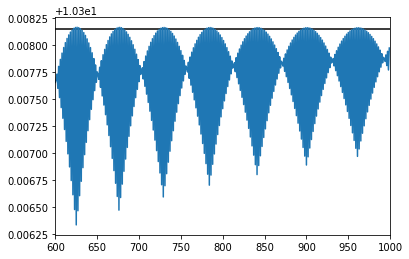

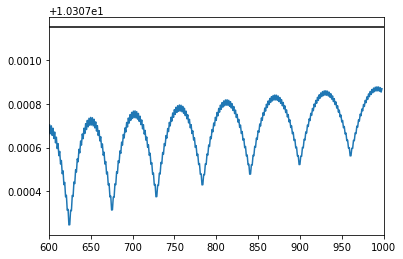

In [11]:
plt.xlim(left, right)
plt.plot([prices[0]]*left +prices)
plt.hlines(BS_price(100, 1, 100, 0.1, 0.1), xmin=0, xmax=right)
plt.show()

plt.xlim(left, right)
plt.plot([prices[0]]*left + [(prices[i-1] +prices[i])/2 for i in range(1, len(prices))])
plt.hlines(BS_price(100, 1, 100, 0.1, 0.1), xmin=0, xmax=right)
plt.show()

## Zadanie 2

In [12]:
args={
    'n':10000, 
    'S_0':100, 
    'T':1, 
    'sigma':0.1, 
    'r':0.1, 
    'K':100
}

In [13]:
def update_mean(means, i, update_value):
    if not means:
        means.append(update_value)
    else:
        means.append(np.average([means[i-1], update_value], weights = [i, 1]))
    return means

def approximation(value_function, St_function, generated_normal_variables,  n, **kwargs):
    means = []
    for i in tqdm(range(0, n)):
        value = value_function(St_function, generated_normal_variables[i], **kwargs)
        means = update_mean(means, i, value)
    return means

def MC_approximation(St_function, Z, S_0, T, sigma, r, K):
    St = St_function(Z, S_0, T, sigma, r)
    return e ** (-r*T) * max(St - K, 0)

def generate_single_S_T(Z, S_0, T, sigma, r):
    return S_0*e**(sigma*sqrt(T)*Z + (r - sigma**2/2)*T)

In [14]:
mc= approximation(MC_approximation,  generate_single_S_T, np.random.normal(size=args['n']), **args)
scipy.stats.describe(mc)

100%|██████████| 10000/10000 [00:00<00:00, 39776.23it/s]


DescribeResult(nobs=10000, minmax=(9.4675259297363, 17.00350901374814), mean=10.45451095436858, variance=0.04037826938896139, skewness=17.454860748607473, kurtosis=470.5075907275655)

(a) metoda zmiennych kontrolnych

In [63]:
def control_variates(St_function, Z, S_0, T, sigma, r, K):
    St = St_function(Z, S_0, T, sigma, r)
    k = e ** (-r*T) * St
    value = e ** (-r*T) * max(St-K, 0) - k + S_0
    return value

In [64]:
cw = approximation(control_variates,  generate_single_S_T, np.random.normal(size=args['n']), **args)
scipy.stats.describe(cw)

100%|██████████| 10000/10000 [00:00<00:00, 35404.53it/s]


DescribeResult(nobs=10000, minmax=(9.516258196404044, 10.44439500986751), mean=10.290024133002943, variance=0.003612498072098288, skewness=-3.3986166662039525, kurtosis=24.833942497447218)

(b) metoda zmiennych kontrolnych w wersji turbo

In [31]:
def generate_S_T_vector(generated_normal_variables, n,K, **kwargs):
    return [generate_single_S_T(generated_normal_variables[i], **kwargs) for i in range(0, n)]

In [61]:
def control_variates_turbo(generated_normal_variables,n, S_0, T, sigma, r, K):
    means = []
    values= []
    X_mean = []
    Y_mean = []
    sum_covariances = 0
    sum_variances= 0
    b= 0
    S_T = generate_S_T_vector(generated_normal_variables, n, **{'S_0':S_0, 'T':T, 'sigma':sigma, 'r':r, 'K':K})
    for i in tqdm(range(0, n)):
        value = e ** (-r*T) * max(S_T[i]-K, 0)
        if not means:
            values.append(value)
            means.append(value)
            X_mean.append(value)
            Y_mean.append(S_T[i])
        else:
            values.append(value)
            X_mean.append(np.average([X_mean[i-1], value], weights = [i, 1]))
            Y_mean.append(np.average([Y_mean[i-1], S_T[i]], weights = [i, 1]))
            sum_covariances = sum((values[j] - X_mean[i])*(S_T[j]- Y_mean[i]) for j in range(0, i))
            sum_variances = sum((S_T[j]- Y_mean[i]) **2 for j in range(0, i))
            b_hat = sum_covariances/sum_variances
            means.append(np.average([means[i-1], value-b_hat*S_T[i]], weights = [i, 1]))
            b=b_hat
    return [x + b*Y_mean[-1] for x in means]

In [62]:
cvt = control_variates_turbo(np.random.normal(size=args['n']), **args)
scipy.stats.describe(cvt)

100%|██████████| 10000/10000 [00:38<00:00, 258.94it/s]


DescribeResult(nobs=10000, minmax=(2.7994041525295614, 93.77873353748278), mean=10.902726444195546, variance=1.1522207151732027, skewness=49.11156459662749, kurtosis=3665.283137122287)

(c) metoda zmiennych antytetycznych

In [65]:
def antitetic_variates(St_function, Z, S_0, T, sigma, r, K):
    St = St_function(Z, S_0, T, sigma, r)
    St_prim = St_function(-Z, S_0, T, sigma, r)
    
    value = e ** (-r*T) * max(St-K, 0)
    value_prim = e ** (-r*T) * max(St_prim-K, 0)
    
    return (value + value_prim)/2

In [66]:
av = approximation(antitetic_variates,  generate_single_S_T, np.random.normal(size=args['n']), **args)
scipy.stats.describe(av)

100%|██████████| 10000/10000 [00:00<00:00, 34781.64it/s]


DescribeResult(nobs=10000, minmax=(9.019562090231442, 12.664147748309512), mean=10.355358845175974, variance=0.0026533681873982247, skewness=11.632441823878855, kurtosis=630.9518690569898)

(d) metoda warstwowania

In [20]:
def generate_wiener_for_layer(n, T, i, k):
    return [sqrt(T)* scipy.stats.norm.ppf(((i-1)+ np.random.uniform())/k) for j in range(0, n)]

def generate_wiener_layers(N_vector, T):
    layers = []
    for i, n in enumerate(N_vector):
        layers.append(generate_wiener_for_layer(n, T, i+1, len(N_vector)))
    return layers

def calculate_S_T(wiener_values, S_0, T, sigma, r):
    return [S_0*e**(sigma*wiener_values[i] + (r - sigma**2/2)*T) for i in range(0, len(wiener_values))]

In [76]:
def stratified_sampling(layers,n, S_0, T, sigma, r, K):
    means = []
    for wiener_values in tqdm(generate_wiener_layers(layers, T)):
        layer_means = []
        S_T = calculate_S_T(wiener_values, S_0, T, sigma, r)
        for i in range(0, len(wiener_values)):
            value = e ** (-r*T) * max(S_T[i]-K, 0)
            if not layer_means:
                layer_means.append(value)
            else:
                layer_means.append(np.average([layer_means[i-1],value], weights = [i, 1]))
        means.append(layer_means)
    return np.average(means, axis=0, weights=[x/len(layers) for x in layers])

In [77]:
scipy.stats.describe(stratified_sampling([100]*100 , **args))

100%|██████████| 100/100 [00:00<00:00, 440.41it/s]


DescribeResult(nobs=100, minmax=(10.246676230507074, 10.311680126985125), mean=10.301223275143816, variance=7.540441804067788e-05, skewness=-3.8181287096435885, kurtosis=19.505909771262765)

(e) metoda importance sampling

In [23]:
def f_Wiener(Y, T):
    return scipy.stats.norm.pdf(Y, scale=T)

def f_Y(Y, mu, T):
    return scipy.stats.norm.pdf(Y, loc=mu, scale=T)

def importance_sampling(St_function, Z, S_0, T, sigma, r, K, mu):
    Y = Z * T + mu
    St = St_function(Y,S_0, T, sigma, r)
    value =  e ** (-r*T) * max(St-K, 0) * (f_Wiener(Y,T)/f_Y(Y, mu, T))
    return value

In [24]:
import_sampl = approximation(importance_sampling, generate_single_S_T, np.random.normal(size=args['n']), **args, mu=0.5)
scipy.stats.describe(import_sampl)

100%|██████████| 10000/10000 [00:02<00:00, 4306.58it/s]


DescribeResult(nobs=10000, minmax=(6.3078418817449995, 12.615683763489999), mean=10.287361829675007, variance=0.014308439054865191, skewness=0.7615665790729493, kurtosis=167.5428084251179)

In [29]:
w = [scipy.stats.describe(approximation(importance_sampling, generate_single_S_T, np.random.normal(size=args['n']), **args, mu=i)).variance for i in np.linspace(-0.5, 2.5, 9)]

100%|██████████| 10000/10000 [00:02<00:00, 3824.85it/s]


[0.11052248434038056,
 0.1062924731693718,
 0.01612433002024737,
 0.01354677762744305,
 0.015617846313814436,
 0.014593484725239383,
 0.08057007450408511,
 0.4676333578540601,
 0.5803810814799844]

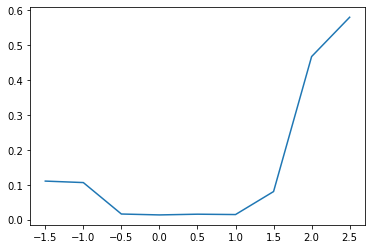

In [30]:
plt.plot(np.linspace(-1.5, 2.5, 9), w)
plt.xticks(np.linspace(-1.5, 2.5, 9))
w

Na podstawie symulacji wybrano $\mu = 0.5$ jako wartość najbardziej minimalizującą wariancję.

In [78]:
mc= approximation(MC_approximation,  generate_single_S_T, np.random.normal(size=args['n']), **args)
cv = approximation(control_variates,  generate_single_S_T, np.random.normal(size=args['n']), **args)
cvt = control_variates_turbo(np.random.normal(size=args['n']), **args)
av = approximation(antitetic_variates,  generate_single_S_T, np.random.normal(size=args['n']), **args)
import_sampling = approximation(importance_sampling, generate_single_S_T, np.random.normal(size=args['n']), **args, mu=0.5)
stratified_sampl = stratified_sampling([100]*10 , **args)

100%|██████████| 10/10 [00:00<00:00, 438.51it/s]


In [79]:

metrices = {
            'mean':lambda x: x.mean,
            'var': lambda x: x.variance,
            'min': lambda x: x.minmax[0],
            'max': lambda x: x.minmax[1],
           }

methods = {
        'MC': mc,
        'Control Variates' : cv,
        'Control Variates Turbo': cvt,
        'Antitetic Variates': av,
        'Importance Sampling': import_sampling,
        'Stratified sampling': stratified_sampl
         }

df = pd.DataFrame()
for method_key, method in methods.items():
    for metric_key, metric in metrices.items():
        df.loc[method_key, metric_key] = metric(scipy.stats.describe(method))
df


,mean,var,min,max
MC,10.178871,0.017858,5.382434,11.138809
Control Variates,10.315122,0.002326,9.516258,10.370976
Control Variates Turbo,10.289407,1.719230,1.469371,112.134249
Antitetic Variates,10.288796,0.002334,9.224269,10.326525
Importance Sampling,10.362961,0.010016,10.159484,13.453124
Stratified sampling,10.359384,0.010037,9.645293,10.680574


Metoda warstwowania powoduje skrócony wektor, dlatego, nie będzie widoczna na wizualizacji. Wizualizacja ze względów czasowych jedynie dla n=1000000 dla 4 metod.

In [80]:
args['n']=1000000
random_normal = np.random.normal(size=args['n'])
mc= approximation(MC_approximation,  generate_single_S_T, random_normal, **args)
cv = approximation(control_variates,  generate_single_S_T, random_normal, **args)
av = approximation(antitetic_variates,  generate_single_S_T, random_normal, **args)
import_sampling = approximation(importance_sampling, generate_single_S_T, random_normal, **args, mu=0.5)

100%|██████████| 1000000/1000000 [03:35<00:00, 4638.55it/s]


In [81]:
methods = {
        'MC': mc,
        'Control Variates' : cv,
        'Antitetic Variates': av,
        'Importance Sampling': import_sampling,
         }

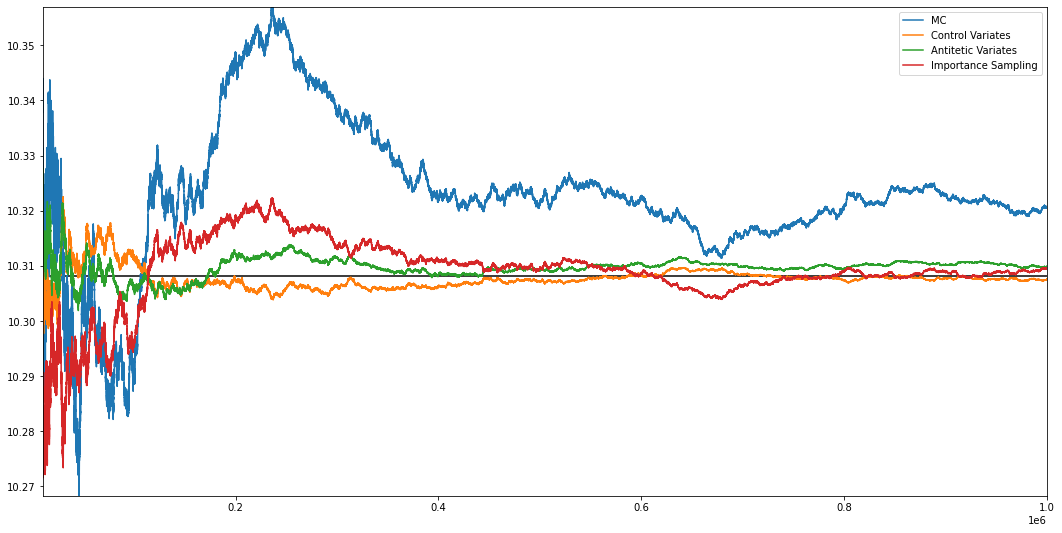

In [82]:
fig, ax = plt.subplots(figsize=(18, 9))
plt.xlim(10**4, 10**6)
plt.ylim(min([min(m[10**4:]) for m in methods.values()]), 
         max([max(m[10**4:]) for m in methods.values()]))
for k, v in methods.items():
    plt.plot(v, label=k)
plt.hlines(BS_price(100, 1, 100, 0.1, 0.1), xmin=0, xmax=10**6)
plt.legend()
plt.show()

## Zadanie 3

In [56]:
def approximation_Asia(value_function, St_function, generated_normal_variables,  n, **kwargs):
    means = []
    St_means= []
    St = St_function(generated_normal_variables, n, **kwargs)
    for i in tqdm(range(0, n)):
        St_means = update_mean(St_means, i, St[i])
        value = value_function(St_means[i], **kwargs)
        means = update_mean(means, i, value)
    return means

def MC_Asia(St_mean, S_0, T, sigma, r, K):
    return e ** (-r*T) * max(St_mean - K, 0)

In [83]:
args['n']=100000
mc_asia = approximation_Asia(MC_Asia, generate_S_T_vector, np.random.normal(size=args['n']), **args)
scipy.stats.describe(mc_asia)

100%|██████████| 100000/100000 [00:04<00:00, 23482.14it/s]


DescribeResult(nobs=100000, minmax=(7.212257990791487, 13.080756958560606), mean=9.557211644324605, variance=0.004419915016984102, skewness=-10.506781433839961, kurtosis=801.532641926686)

Wycena opcji Azjatyckiej dla średniej geometrycznej w chwili $T=0$ (źródło: https://macsphere.mcmaster.ca/bitstream/11375/23088/2/Zeng_Jin_201712_MasterofScience.pdf):

In [84]:
def BS_price_Asia_geo_avg(S0, T, K, sigma, r):
    return e**(-r*T) *(S0* e**(r*T)* norm.cdf(d1(S0, T, K, sigma, r)) - K*norm.cdf(d2(S0, T, K, sigma, r)))

BS_price_Asia_geo_avg(100, 1, 100, 0.1, 0.1)

10.308150925634413

## Zadanie 4

In [59]:
S_0 = 100
sigma = 1
r = 0.1
K_2 = 125
K_1 = 115
T=10

Niestety nie zdążyłem wykonać wycen dla 2 ostatnich zadań. 

Potwierdzam samodzielność powyższej pracy oraz niekorzystanie przeze mnie z niedozwolonych źródeł. Stanisław Pawlak